In [1]:
![ -d ./sample_data/ ] && rm -rf ./sample_data/

In [2]:
!pip install transformers &>/dev/null

In [3]:
!wget https://www.dropbox.com/s/r9d1f3ve471osob/Train_rev1.zip?dl=1 -O data.zip &> /dev/null
!unzip -e data.zip &>/dev/null

In [4]:
import torch, torch.nn as nn
from transformers import AutoTokenizer, AutoModel, pipeline
from torch.autograd import Variable

In [30]:
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [6]:
# <A whole lot of your code. Feel free to format it as you see fit>

from transformers import RobertaTokenizer, RobertaModel

tokenizer=RobertaTokenizer.from_pretrained ('roberta-base', )
model=RobertaModel.from_pretrained ('roberta-base')
print ('tokenizer and model downloaded')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer and model downloaded


In [7]:
# path="drive/MyDrive/HSE/Deep Learning/week07_attention/"

# titleix_train=torch.load(path+'titleix_train.pt', map_location=torch.device('cpu'))
# titleix_val=torch.load(path+'titleix_val.pt', map_location=torch.device('cpu'))

# descix_train=torch.load(path+'descix_train.pt', map_location=torch.device('cpu'))
# descix_val=torch.load(path+'descix_val.pt', map_location=torch.device('cpu'))

# data_train=pd.read_csv(path+'data_train.csv')
# data_val=pd.read_csv(path+'data_test.csv')

In [8]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string
data[text_columns]=data[text_columns].fillna("unknown") # cast "unknown" to NaN
data.FullDescription=data.FullDescription.apply(lambda x: x[:100])
# text_columns = ["TitleIx", "DescIx"]

data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986


In [9]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [10]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [ ]:
# del data

In [ ]:
# TitleIx_train=tokenizer(data_train.Title.values.tolist(), truncation=True, padding=True, return_tensors='pt').to('cuda')
# DescIx_train=tokenizer(data_train.FullDescription.values.tolist(), truncation=True, padding=True, return_tensors='pt').to('cuda')

# TitleIx_val=tokenizer(data_val.Title.values.tolist(), truncation=True, padding=True, return_tensors='pt').to('cuda')
# DescIx_val=tokenizer(data_val.FullDescription.values.tolist(), truncation=True, padding=True, return_tensors='pt').to('cuda')

In [ ]:
# path="drive/MyDrive/HSE/Deep Learning/week07_attention/"

# data_train.to_csv(path+"data_train.csv")
# data_val.to_csv(path+"data_test.csv")

# torch.save(TitleIx_train, path+"titleix_train.pt")
# torch.save(TitleIx_val, path+"titleix_val.pt")

# torch.save(DescIx_train, path+"descix_train.pt")
# torch.save(DescIx_val, path+"descix_val.pt")

In [11]:
dev = 'cuda'

In [12]:
def generate_batch (data=None, batch_size=16, replace=True, text_columns=text_columns):
  
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = data[col].values
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
class TitleEncoder (nn.Module):

  def __init__ (self, tokenizer=tokenizer, model=model, out_size=64):
    super(self.__class__, self).__init__()
    self.model=model
    self.dense=nn.LazyLinear (out_size)
    self.tokenizer=tokenizer
    self.relu=nn.ReLU()

  def forward (self, X):
    
    # output=tokenizer(X.tolist(), truncation=True, padding=True, return_tensors='pt').to('cuda')
    output=self.model (**X)['pooler_output']

    output=self.dense (output)
    output=self.relu(output)

    return output

In [19]:
class DescriptionEncoder (nn.Module):

  def __init__ (self, tokenizer=tokenizer, model=model, out_size=64):
    super(self.__class__, self).__init__()
    self.model=model
    self.dense=nn.LazyLinear (out_size)
    self.tokenizer=tokenizer
    self.relu=nn.ReLU()

  def forward (self, X):
    
    # output=tokenizer(X.tolist(), truncation=True, padding=True, return_tensors='pt').to('cuda')
    output=self.model (**X)['pooler_output']

    output=self.dense (output)
    output=self.relu(output)

    return output

In [20]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        # <YOUR CODE>
        self.cat_encoder=nn.Sequential (
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU (),
            nn.LazyLinear(64),
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        # <YOUR CODE>
        self.output=nn.Sequential (
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.LazyLinear(n_cat_features),
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        # desc_h = <YOUR CODE>
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        # cat_h = <YOUR CODE>
        cat_h=self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        del title_h
        del desc_h
        del cat_h
        
        # ... and stack a few more layers at the top
        # <YOUR CODE>
        joint_h=self.output(joint_h)[:, 0]

        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        # return <YOUR CODE>
        return joint_h

In [21]:
ntwk = FullNetwork().to(dev)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [22]:
# test it on one batch

batch = generate_batch(data_train, 16)
print (len(batch))

title_ix =tokenizer(batch['Title'].tolist(), truncation=True, padding=True, return_tensors='pt').to(dev)
desc_ix = tokenizer(batch["FullDescription"].tolist(), truncation=True, padding=True, return_tensors='pt').to(dev)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(dev)
reference = Variable(torch.FloatTensor(batch[target_column])).to(dev)

torch.cuda.empty_cache()
prediction = ntwk(title_ix, desc_ix, cat_features)

del desc_ix
del cat_features
# del reference
del batch

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix["input_ids"].shape[0]
del title_ix

# del prediction

4


In [23]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """ 
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [24]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, ntwk.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

In [25]:
del prediction
del reference
del loss
del dummy_grads

In [26]:
def iterate_minibatches(data, batch_size=16, max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tqdm.notebook.trange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]])

In [35]:
ntwk = FullNetwork().to(dev)
opt = torch.optim.Adam(model.parameters(), lr=1e-6)

num_epochs = 100
batch_size = 32
batches_per_epoch = 100

from IPython.display import clear_output
train_LOSS=[]
train_MAE=[]
val_LOSS=[]
val_MAE=[]
path="drive/MyDrive/HSE/Deep Learning/week07_attention/"

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


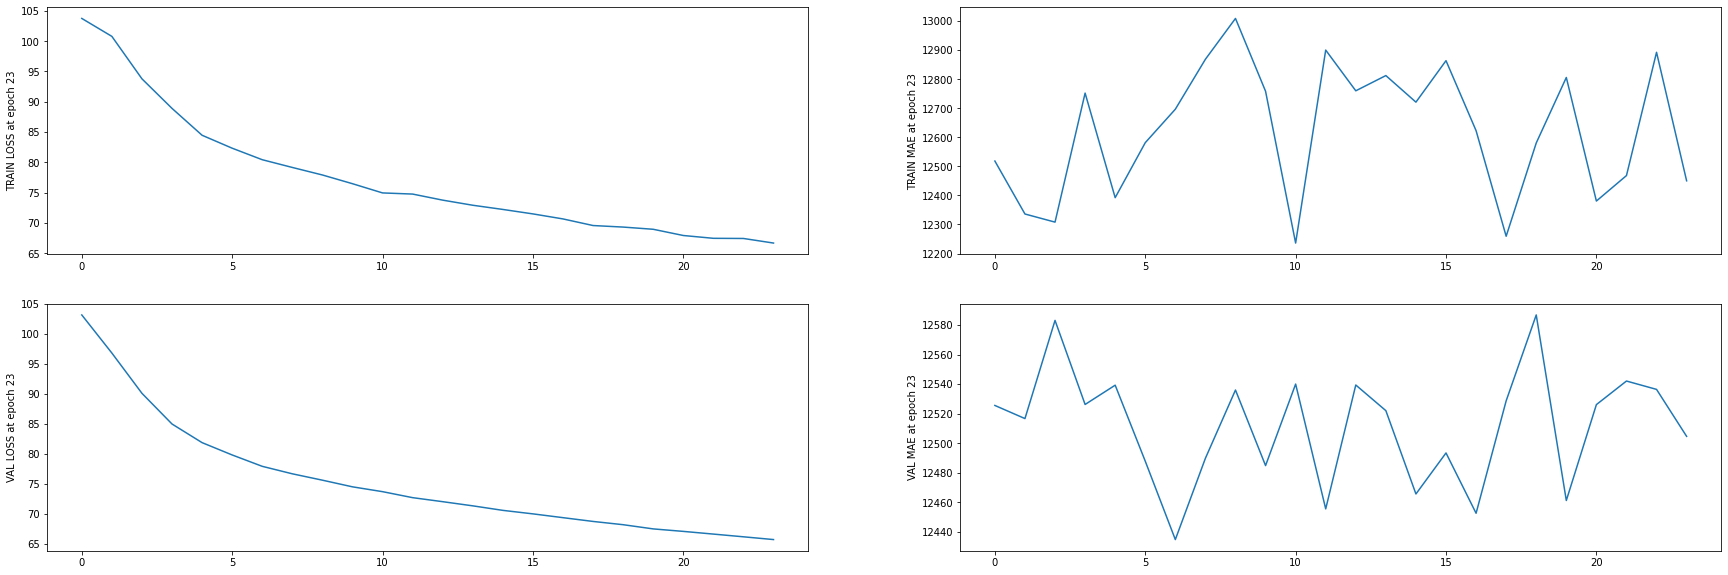


Currently:

	Train Loss:	66.69461
	Train MAE:	12450.28696
	Val Loss:	65.67653
	Val MAE:	12504.64831



Training at epoch 24:


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [36]:
for epoch_i in range(num_epochs):
    
    print(f"Training at epoch {epoch_i}:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        # print (len(batch))

        title_ix =tokenizer(batch['Title'].tolist(), truncation=True, padding=True, return_tensors='pt').to(dev)
        desc_ix = tokenizer(batch["FullDescription"].tolist(), truncation=True, padding=True, return_tensors='pt').to(dev)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(dev)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(dev)

        torch.cuda.empty_cache()
        prediction = ntwk(title_ix, desc_ix, cat_features)

        del desc_ix
        del cat_features
        del title_ix

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.cpu().numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1

        del loss
        del prediction
        del reference
    
    train_LOSS.append(train_loss/train_batches)
    train_MAE.append(train_mae/train_batches)

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print(f"Validation at epoch {epoch_i}:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False, max_batches=10000):
            title_ix =tokenizer(batch['Title'].tolist(), truncation=True, padding=True, return_tensors='pt').to(dev)
            desc_ix = tokenizer(batch["FullDescription"].tolist(), truncation=True, padding=True, return_tensors='pt').to(dev)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(dev)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(dev)

            prediction = ntwk(title_ix, desc_ix, cat_features)

            del desc_ix
            del cat_features
            del title_ix            

            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1

            del loss
            del prediction
            del reference

    val_LOSS.append(val_loss/val_batches)
    val_MAE.append(val_mae/val_batches)
    if min(val_MAE)==(val_mae/val_batches):
      torch.save(model.state_dict(), path+"ntwk_fine_tuned.ckpt")

    clear_output(True)
    y=np.arange (len(train_LOSS))
    plt.figure (figsize=(30, 10))
    plt.title (f"Epoch {epoch_i}")

    colors=['b']*len(train_LOSS)
    colors[-1]='r'
    plt.subplot (221)
    plt.plot(y, np.array(train_LOSS))
    plt.ylabel (f"TRAIN LOSS at epoch {epoch_i}")
    
    plt.subplot(222)
    plt.plot (y, np.array(train_MAE))
    plt.ylabel (f"TRAIN MAE at epoch {epoch_i}")
    
    plt.subplot(223)
    plt.plot (y, np.array(val_LOSS))
    plt.ylabel (f"VAL LOSS at epoch {epoch_i}")
    
    plt.subplot(224)
    plt.plot (y, np.array(val_MAE))
    plt.ylabel (f"VAL MAE at epoch {epoch_i}")

    plt.show()

    print("\nCurrently:\n")
    print("\tTrain Loss:\t%.5f" % (train_loss / train_batches))
    print("\tTrain MAE:\t%.5f" % (train_mae / train_batches))
    print("\tVal Loss:\t%.5f" % (val_loss / val_batches))
    print("\tVal MAE:\t%.5f" % (val_mae / val_batches))
    print("\n\n")